# Neural networks

In [320]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Back propagation

### Load and preprocess the Boston housing dataset

In [321]:
data, target = ds.load_boston(return_X_y=True)

In [490]:
data_train, data_valid, labels_train, labels_valid = train_test_split(data[:, [5, 8, 12]], target, test_size=0.5)

In [491]:
def preprocess_data(data):
    normalized_data = (data - data.mean(axis=0)) / data.std(axis=0)
    return np.concatenate([np.ones_like(normalized_data[:, 0:1]), normalized_data], axis=1)

def preprocess_labels(labels):
    return 2 * (labels - (max(labels) + min(labels)) / 2) / (max(labels) - min(labels))

def restore_labels(labels, original_labels):
    return (max(original_labels) - min(original_labels)) * labels / 2 + ((max(original_labels) + min(original_labels)) / 2)

In [492]:
X_train, X_valid = map(preprocess_data, [data_train, data_valid])
t_train, t_valid = map(preprocess_labels, [labels_train, labels_valid])

### Initialize the weights and training parameters

In [493]:
rows, columns = X_train.shape

w = 0.1 * np.random.random(columns)
weight_history = [], [], [], []
rel_rmse_history = [], []

num_epochs = 100
eta = 0.001
k = 0

### Train

In [494]:
def predict(data, w):
    return np.tanh(data.dot(w))

def gradients_and_error(data, labels, w):
    yk = predict(data, w)
    err = yk - labels
    g = data.T * ((1 - yk**2) * err)
    
    return g, err

In [495]:
def relative_errors(gt, preds):
    epsilon = 1e-6
    return gt / (np.abs(gt) + epsilon) - preds / (np.abs(gt) + epsilon)

def relative_rmse(gt, preds): 
    return np.sqrt((relative_errors(gt, preds)**2).mean())

def relative_rmse_restored(gt, data, original_gt):
    return [f(restore_labels(gt, original_gt), restore_labels(predict(data, w), original_gt)) for f in [relative_rmse, relative_errors]]

In [496]:
for m in range(num_epochs):
    for n in range(rows):
        g, _ = gradients_and_error(X_train[n:n+1], t_train[n:n+1], w)
        w = w - eta*g.flatten()
        k += 1
        for i, weight in enumerate(weight_history):
            weight.append([k, w[i]])
            
        rel_rmse_train, _ = relative_rmse_restored(t_train, X_train, labels_train)
        rel_rmse_valid, _ = relative_rmse_restored(t_valid, X_valid, labels_valid)
        rel_rmse_history[0].append(rel_rmse_train)
        rel_rmse_history[1].append(rel_rmse_valid)

### Visualize weight changes

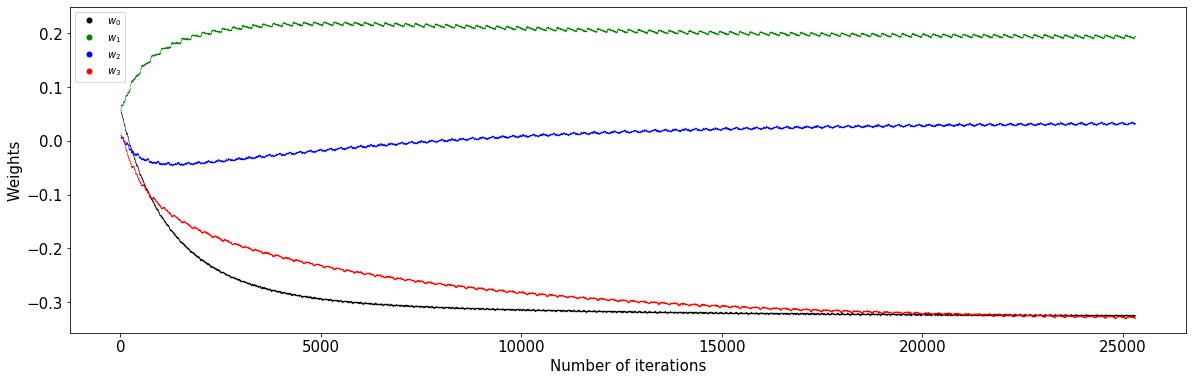

In [497]:
plt.figure(figsize=(20, 6))
for i, [color, weight] in enumerate(zip(['k.', 'g.', 'b.', 'r.'], weight_history)):
    plt.plot(*zip(*weight), color, markersize=0.1, label=f'$w_{i}$')
    
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('Weights', fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(markerscale=100)
plt.show()

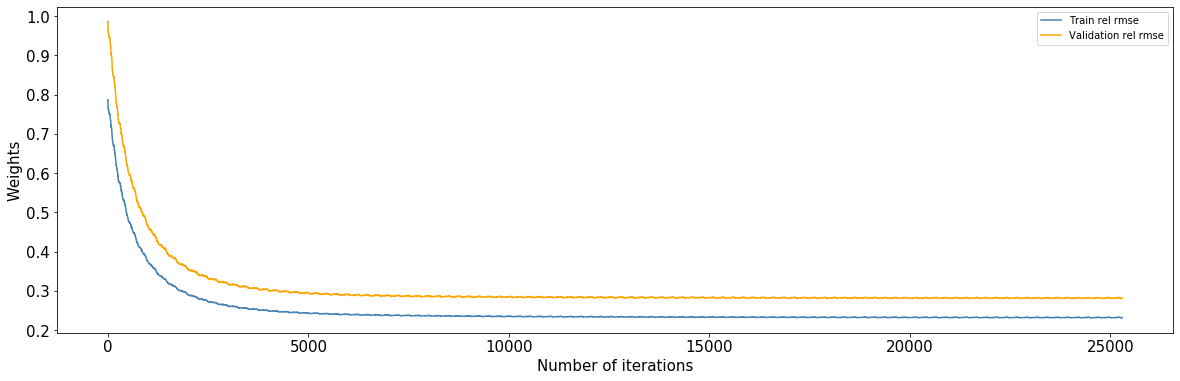

In [498]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(rel_rmse_history[0])), rel_rmse_history[0], color='steelblue', markersize=0.1, label=f'Train rel rmse')
plt.plot(range(len(rel_rmse_history[1])), rel_rmse_history[1], color='orange', markersize=0.1, label=f'Validation rel rmse')
    
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('Weights', fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(markerscale=100)
plt.show()

### Evaluate

In [502]:
rel_rmse_train, rel_errors_train = relative_rmse_restored(t_train, X_train, labels_train)
rel_rmse_valid, rel_errors_valid = relative_rmse_restored(t_valid, X_valid, labels_valid)

In [503]:
print(f'Relative rmse train: {rel_rmse_train:.3f}')
print(f'Relative rmse validation: {rel_rmse_valid:.3f}')

Relative rmse train: 0.232
Relative rmse validation: 0.281


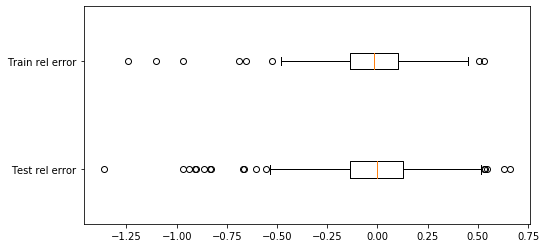

In [505]:
plt.figure(figsize=(8, 4))
plt.boxplot([rel_errors_valid, rel_errors_train], vert=False, labels=['Test rel error', 'Train rel error'])
plt.show()